In [1]:
from diff_classifier import aws as aws

import pandas as pd
import skimage.io as sio
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from skimage.filters import sobel, prewitt, scharr, gaussian, median, rank
from skimage.morphology import square, opening, closing, skeletonize, star, disk, dilation
from skimage.morphology import remove_small_objects, reconstruction, white_tophat
from skimage.feature import canny
from scipy.ndimage.morphology import binary_fill_holes
from skimage.measure import regionprops, label
from skan import csr, draw
import numpy as np
from skimage.util import pad, img_as_uint

from diff_register import im_process as imp

from scipy import ndimage as ndi
from skimage.morphology import watershed
from skimage.feature import peak_local_max

In [6]:
filename = 'P1_S2_Z3.tif'
folder = 'Tissue_Studies/01_30_19_cell_uptake/peg_noserum'
bucket = 'ccurtis.data'

In [121]:
aws.download_s3('{}/{}'.format(folder, filename), filename, bucket_name=bucket)
image_raw = sio.imread(filename)

In [122]:
image_raw.shape

(10626, 8293, 3)

In [123]:
image = image_raw[:, :, 1]

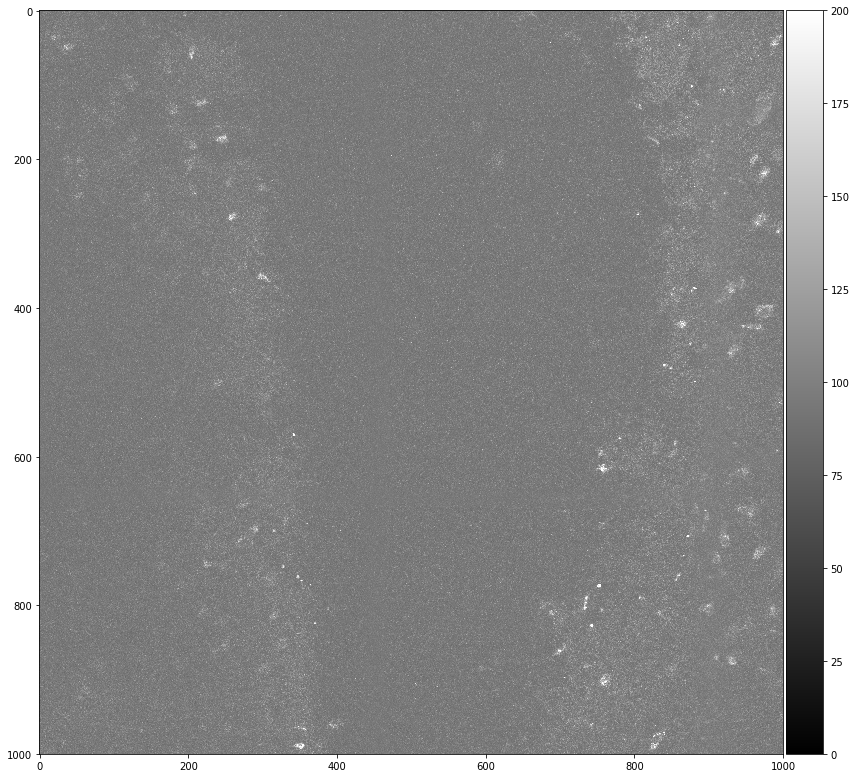

In [71]:
plt.figure(figsize=(12,12))
sio.imshow(img, cmap='gray', vmin=0, vmax=200)

In [124]:
img = image[2500:3500, 7000:8000]

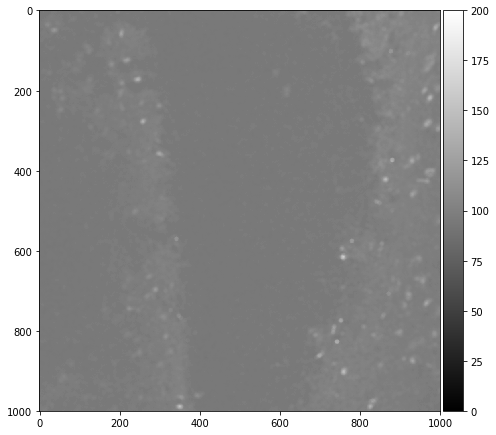

In [104]:
#img = image[3000:4000, 1500:2500]
backlevel = 2
filt_image = rank.mean(img, selem=star(4))
edges = prewitt(filt_image)
closeim = closing(edges, selem=star(2))
openim = img_as_uint(opening(closeim, selem=star(2)))
backg = backlevel #1*rank.mean(openim, selem=star(30))
binarim = openim > backg
filled_im = binary_fill_holes(binarim)
clean_im2 = remove_small_objects(filled_im, min_size=60)

plt.figure(figsize=(7,7))
sio.imshow(filt_image, cmap='gray', vmin=0, vmax=200)
plt.show()

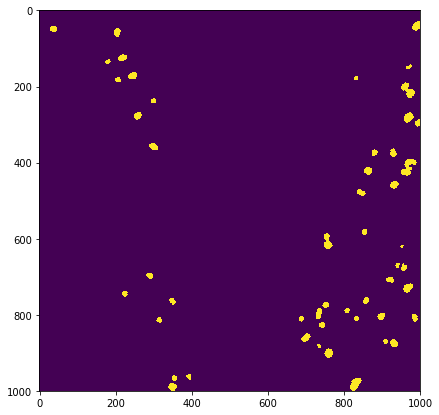

In [105]:
plt.figure(figsize=(7,7))
plt.imshow(clean_im2)
plt.show()

In [2]:
#image = img
def binarize_cells(image, backlevel=8):
    filt_size = 2
    elem_size = 1
    min_size = 100
    
    filt_image = rank.mean(image, selem=star(filt_size))
    edges = prewitt(filt_image)
    closeim = closing(edges, selem=star(elem_size))
    openim = img_as_uint(opening(closeim, selem=star(elem_size)))
    backg = backlevel #1*rank.mean(openim, selem=star(30))
    binarim = openim > backg
    filled_im = binary_fill_holes(binarim)
    clean_im2 = remove_small_objects(filled_im, min_size=min_size)

    # # implementation of watershed
    padw = 150
    cleanpad = pad(clean_im2, ((padw, padw),), mode='constant')
    distance = ndi.distance_transform_edt(cleanpad)
    local_maxi = peak_local_max(distance, indices=False,
                                footprint=np.ones((90, 90)),
                                labels=cleanpad)
    markers = ndi.label(local_maxi)[0]
    labels = watershed(-distance, markers, mask=cleanpad)
    labels = labels[padw:-padw, padw:-padw]

    label_edge = scharr(labels)
    label_edge = label_edge < 0.000000000001
    split_cells = np.logical_and(label_edge, clean_im2)
    split_cells = remove_small_objects(split_cells, min_size=min_size)

    plt.figure(figsize=(7,7))
    sio.imshow(split_cells, cmap='gray', vmin=0, vmax=0.001)
    plt.show()
    return split_cells

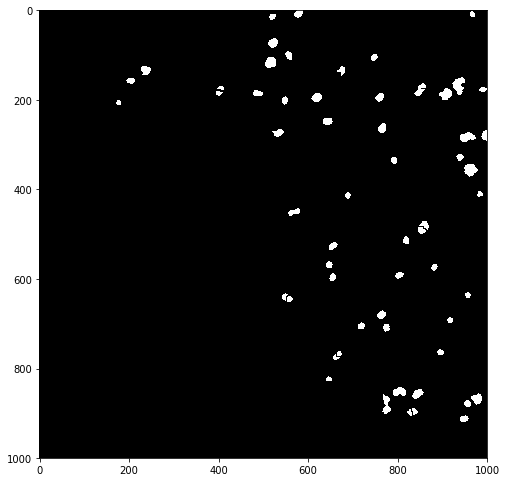

In [125]:
split_cells = binarize_cells(img, backlevel=17)

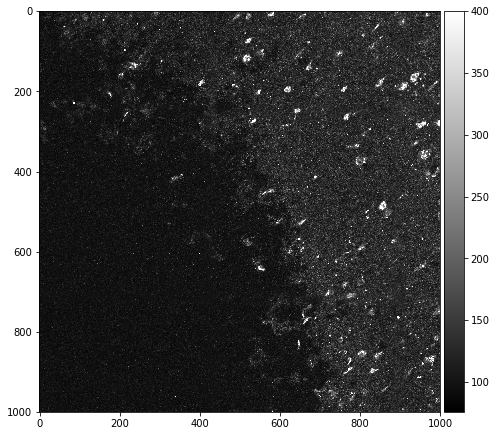

In [126]:
plt.figure(figsize=(7,7))
sio.imshow(img, cmap='gray', vmax=400)

In [3]:
def filled_cells(binary_im, intensity_image):
    
    labelim = label(binary_im)
    intim = intensity_image
    props = regionprops(labelim, intensity_image=intim)
    
    areas = np.zeros(len(props))
    ints = np.zeros(len(props))

    counter = 0
    for prop in props:
        areas[counter] = prop.area
        ints[counter] = prop.mean_intensity

        counter += 1
    
    datas = {'area': areas, 'mean_intensity': ints} 
    data = pd.DataFrame(datas)
    data['total_intensity'] = data.area * data.mean_intensity
    data['p_covered5'] = data.total_intensity/(5*data.area)
    data['p_covered10'] = data.total_intensity/(10*data.area)
    data['p_covered15'] = data.total_intensity/(15*data.area)
    data['p_covered20'] = data.total_intensity/(20*data.area)
    data['p_covered40'] = data.total_intensity/(40*data.area)
    
    return data

In [12]:
def cell_analysis(filename, folder, bucket):
    aws.download_s3('{}/{}'.format(folder, filename), filename, bucket_name=bucket)
    image_raw = sio.imread(filename)
    image = image_raw[0, :, :]
    intensity_image = image_raw[1, :, :]
    
    backg = input('Background level: ')
    backg = int(backg)
    split_cells = binarize_cells(image[2500:4500, 3500:5500], backlevel=backg)
    variable = input('Does this image look good?: ')
    
    if variable == 'yes':
        split_cells = binarize_cells(image, backlevel=backg)
        data = filled_cells(split_cells, intensity_image)
        prefix = filename.split('.tif')[0]
        dfilename = '{}.csv'.format(prefix)
        bfilename = 'bi_{}'.format(filename)
        data.to_csv(dfilename)
        plt.imsave(bfilename, split_cells)
        aws.upload_s3(dfilename, '{}/{}'.format(folder, dfilename), bucket_name=bucket)
        aws.upload_s3(bfilename, '{}/{}'.format(folder, bfilename), bucket_name=bucket)
        return data, split_cells
    else:
        backg = input('New background level: ')
        backg = int(backg)
        split_cells = binarize_cells(image, backlevel=backg)
        
        data = filled_cells(split_cells, intensity_image)
        prefix = filename.split('.tif')[0]
        dfilename = '{}.csv'.format(prefix)
        bfilename = 'bi_{}'.format(filename)
        data.to_csv(dfilename)
        plt.imsave(bfilename, split_cells)
        aws.upload_s3(dfilename, '{}/{}'.format(folder, dfilename), bucket_name=bucket)
        aws.upload_s3(bfilename, '{}/{}'.format(folder, bfilename), bucket_name=bucket)
        return data, split_cells

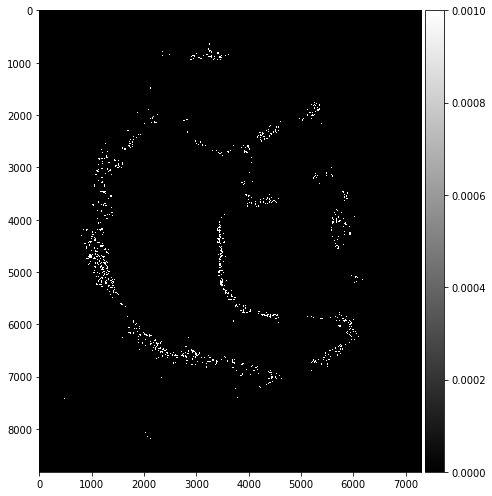

Does this image look good?: yes


TypeError: filled_cells() takes 1 positional argument but 2 were given

In [46]:
data, split_cells = cell_analysis(filename, folder, bucket)

In [56]:
plt.imsave('test.tif', split_cells)

In [55]:
split_cells

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [21]:
data = filled_cells(split_cells)

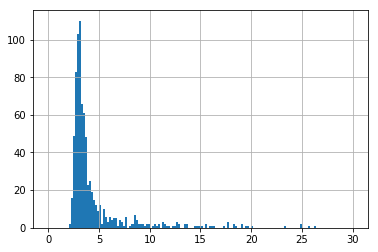

In [22]:
data['mean_intensity'].hist(bins=np.linspace(0, 30, 151))

(0, 50)

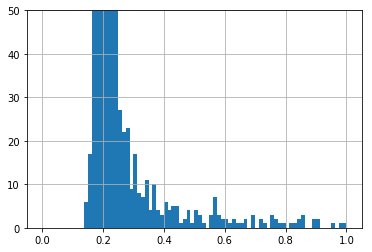

In [23]:
data['p_covered15'].hist(bins=np.linspace(0, 1, 81))
plt.ylim([0, 50])

In [24]:
filled = data.p_covered15 > 0.25
np.mean(filled)

0.3337531486146096

cooh_noserum
15
P2_S3_Z1.tif
Background level: 10


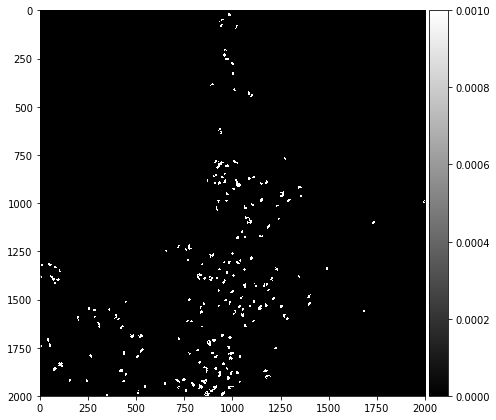

Does this image look good?: yes


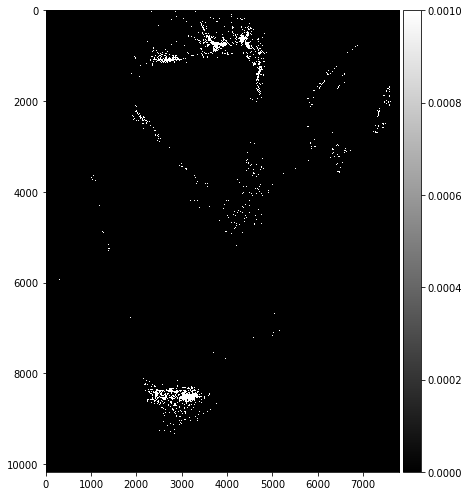

cooh_noserum
16
P2_S3_Z2.tif
Background level: 12


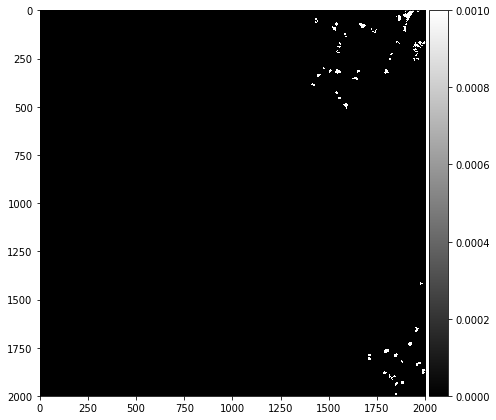

Does this image look good?: yes


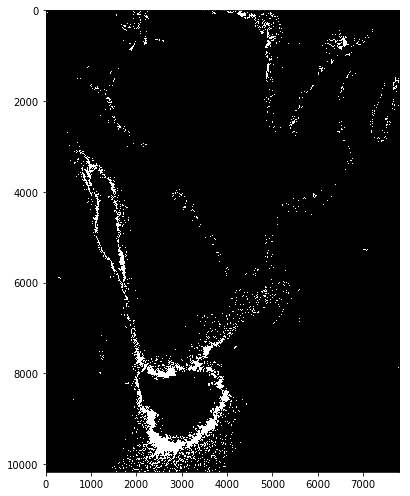

cooh_noserum
17
P2_S3_Z3.tif
Background level: 17


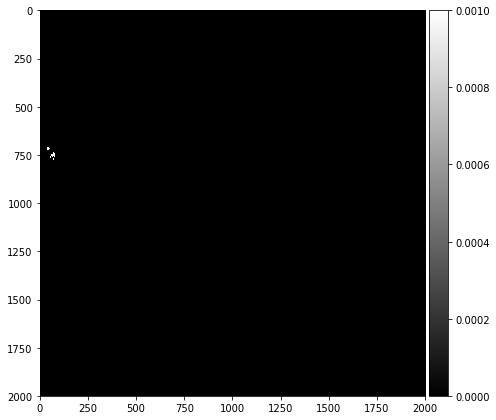

Does this image look good?: no
New background level: 16


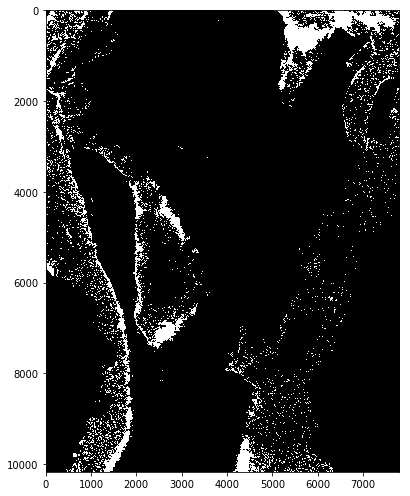

In [17]:
data = {}
counter = 0
skips = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71]
for typ in ['cooh_noserum', 'cooh_serum', 'peg_noserum', 'peg_serum']:
    for pup in [1, 2]:
        for slic in [1, 2, 3]:
            for z in [1, 2, 3]:
                
                if counter not in skips:
                    filename = 'P{}_S{}_Z{}.tif'.format(pup, slic, z)
                    print(typ)
                    print(counter)
                    print(filename)
                    prefix = '{}_P{}_S{}_Z{}'.format(typ, pup, slic, z)
                    folder = 'Tissue_Studies/01_30_19_cell_uptake/{}'.format(typ)
                    data[prefix], split_cells = cell_analysis(filename, folder, bucket)
                
                counter += 1

In [43]:
counter = 0
for typ in ['cooh_noserum', 'cooh_serum', 'peg_noserum', 'peg_serum']:
    for pup in [1, 2]:
        for slic in [1, 2, 3]:
            for z in [1, 2, 3]:
                folder = 'Tissue_Studies/01_30_19_cell_uptake/{}'.format(typ)
                filename = 'P{}_S{}_Z{}.csv'.format(pup, slic, z)
                new_name = '{}_{}'.format(typ, filename)
                aws.download_s3('{}/{}'.format(folder, filename), new_name, bucket_name=bucket)
                
                if counter ==0:
                    data = pd.read_csv(new_name, index_col='Unnamed: 0')
                    data['Type'] = typ
                    data['Pup'] = pup
                    data['Slice'] = slic
                    data['Z'] = z
                    data['Sample'] = '{}_P{}_S{}_Z{}'.format(typ, pup, slic, z)
                    data['Zstack'] = '{}_P{}_S{}'.format(typ, pup, slic)
                    data['ByPup'] = '{}_P{}'.format(typ, pup)
                    data['PupSlice'] = 'P{}_S{}'.format(pup, slic)
                    
                else:
                    new_data = pd.read_csv(new_name, index_col='Unnamed: 0')
                    new_data['Type'] = typ
                    new_data['Pup'] = pup
                    new_data['Slice'] = slic
                    new_data['Z'] = z
                    new_data['Sample'] = '{}_P{}_S{}_Z{}'.format(typ, pup, slic, z)
                    new_data['Zstack'] = '{}_P{}_S{}'.format(typ, pup, slic)
                    new_data['ByPup'] = '{}_P{}'.format(typ, pup)
                    new_data['PupSlice'] = 'P{}_S{}'.format(pup, slic)
                    
                    data = data.append(new_data)
                
                counter += 1

In [44]:
data = data.reset_index(drop=True)

In [94]:
data['p_covered400'] = data.total_intensity/(400*data.area)

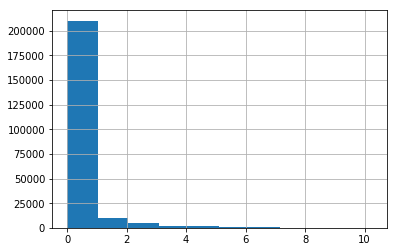

In [95]:
data['p_covered400'].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000000120839B0>,
      dtype=object)

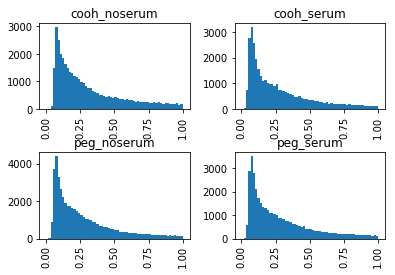

In [30]:
plt.figure(figsize=(10,10))
data.hist(column='p_covered40', by='Type', bins=np.linspace(0, 1, 61))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000FC36710>,
      dtype=object)

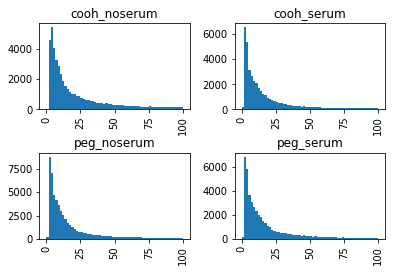

In [32]:
data.hist(column='mean_intensity', by='Type', bins=np.linspace(0, 100, 61))

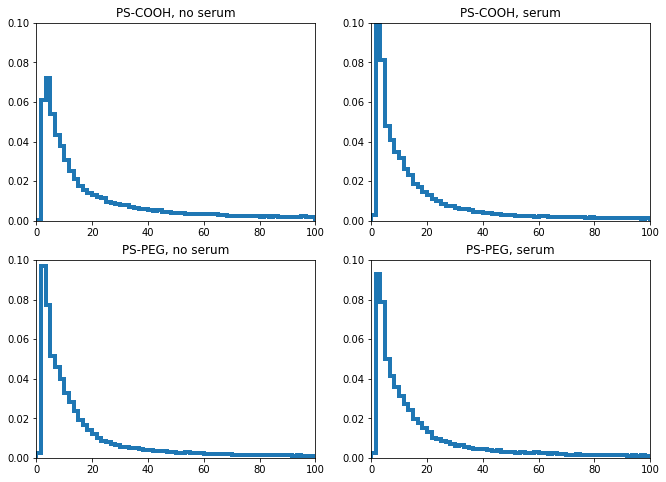

In [42]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(11, 8))
axes = [item for sublist in axes for item in sublist]
titles = ['PS-COOH, no serum', 'PS-COOH, serum', 'PS-PEG, no serum', 'PS-PEG, serum']

for ax, typ, title in zip(axes, ['cooh_noserum', 'cooh_serum', 'peg_noserum', 'peg_serum'], titles):

    ax.hist(data[data['Type']==typ]['mean_intensity'], bins=np.linspace(0, 100, 61), normed=True, histtype='step', linewidth=4)
    ax.set_title(title)
    ax.set_xlim([0, 100])
    ax.set_ylim([0, 0.1])

In [35]:
axes = [item for sublist in axes for item in sublist]

Type: cooh_noserum, Sample: P1_S1, % uptake: 0.28944654520453766
Type: cooh_noserum, Sample: P1_S2, % uptake: 0.09847365829640571
Type: cooh_noserum, Sample: P1_S3, % uptake: 0.37781579697747364
Type: cooh_noserum, Sample: P2_S1, % uptake: 0.7545073757057003
Type: cooh_noserum, Sample: P2_S2, % uptake: 0.11784115012962526
Type: cooh_noserum, Sample: P2_S3, % uptake: 0.14523901310717038
Type: cooh_serum, Sample: P1_S1, % uptake: 0.06581415174765558
Type: cooh_serum, Sample: P1_S2, % uptake: 0.5859613428280773
Type: cooh_serum, Sample: P1_S3, % uptake: 0.5209370424597365
Type: cooh_serum, Sample: P2_S1, % uptake: 0.3137053945774714
Type: cooh_serum, Sample: P2_S2, % uptake: 0.21989996427295463
Type: cooh_serum, Sample: P2_S3, % uptake: 0.18066186402521386
Type: peg_noserum, Sample: P1_S1, % uptake: 0.068810770381451
Type: peg_noserum, Sample: P1_S2, % uptake: 0.547993905535805
Type: peg_noserum, Sample: P1_S3, % uptake: 0.4842345555714082
Type: peg_noserum, Sample: P2_S1, % uptake: 0.315

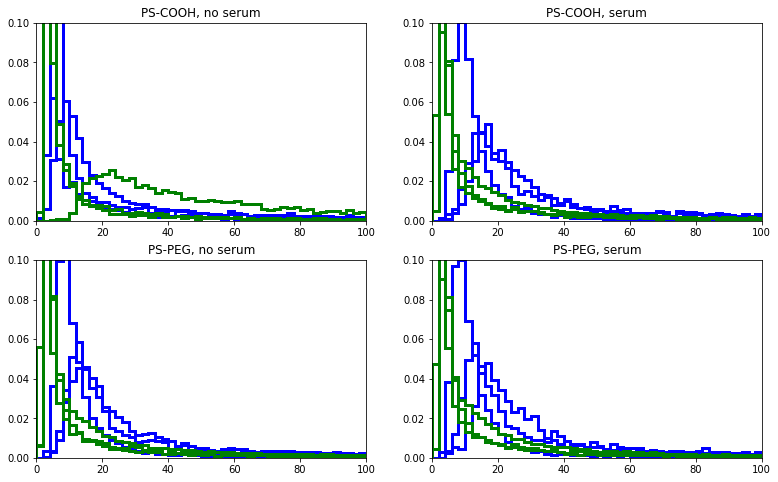

In [79]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(13, 8))
axes = [item for sublist in axes for item in sublist]
titles = ['PS-COOH, no serum', 'PS-COOH, serum', 'PS-PEG, no serum', 'PS-PEG, serum']
cell_uptake = {}
for ax, typ, title in zip(axes, ['cooh_noserum', 'cooh_serum', 'peg_noserum', 'peg_serum'], titles):
    cell_uptake[typ] = []
    for sample in data['PupSlice'].unique():
        if 'S1' in sample:
            label = sample.split('_')[0]
        if 'P1' in sample:
            color = 'b'
        else:
            color = 'g'
        ax.hist(data[(data['Type']==typ) & (data['PupSlice']==sample)]['mean_intensity'],
                bins=np.linspace(0, 100, 51), normed=True, histtype='step', linewidth=3,
                color=color, label=label)
        greater = data[(data['Type']==typ) & (data['PupSlice']==sample)]['mean_intensity'] > 40
        print('Type: {}, Sample: {}, % uptake: {}'.format(typ, sample, greater.mean()))
        cell_uptake[typ].append(greater.mean())
    ax.set_title(title)
    ax.set_xlim([0, 100])
    ax.set_ylim([0, 0.1])

Type: cooh_noserum, Sample: P1_S1, % uptake: 0.12616019250601582
Type: cooh_noserum, Sample: P1_S2, % uptake: 0.022156573116691284
Type: cooh_noserum, Sample: P1_S3, % uptake: 0.20055127839558978
Type: cooh_noserum, Sample: P2_S1, % uptake: 0.4979663692102228
Type: cooh_noserum, Sample: P2_S2, % uptake: 0.041480084845628096
Type: cooh_noserum, Sample: P2_S3, % uptake: 0.06264456437933694
Type: cooh_serum, Sample: P1_S1, % uptake: 0.02011935208866155
Type: cooh_serum, Sample: P1_S2, % uptake: 0.4248897931502204
Type: cooh_serum, Sample: P1_S3, % uptake: 0.30600292825768666
Type: cooh_serum, Sample: P2_S1, % uptake: 0.16649585390850646
Type: cooh_serum, Sample: P2_S2, % uptake: 0.0969989281886388
Type: cooh_serum, Sample: P2_S3, % uptake: 0.08509680324178298
Type: peg_noserum, Sample: P1_S1, % uptake: 0.020835559354631904
Type: peg_noserum, Sample: P1_S2, % uptake: 0.4080751650584053
Type: peg_noserum, Sample: P1_S3, % uptake: 0.2959052646597232
Type: peg_noserum, Sample: P2_S1, % uptake

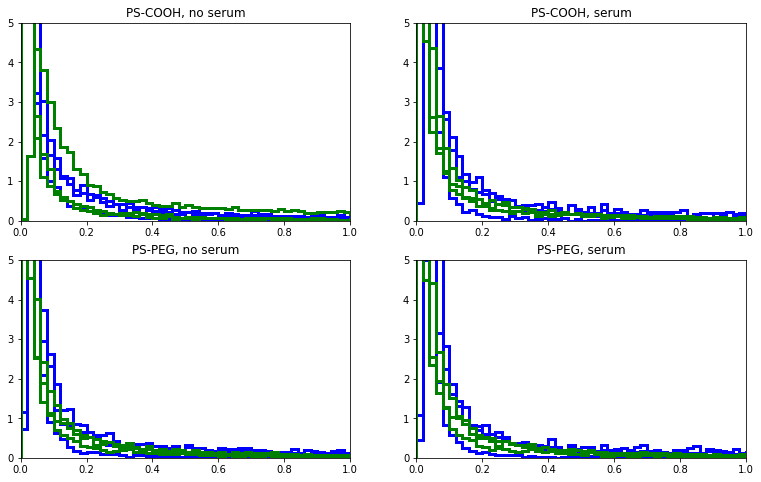

In [109]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(13, 8))
axes = [item for sublist in axes for item in sublist]
titles = ['PS-COOH, no serum', 'PS-COOH, serum', 'PS-PEG, no serum', 'PS-PEG, serum']
cell_uptake = {}
for ax, typ, title in zip(axes, ['cooh_noserum', 'cooh_serum', 'peg_noserum', 'peg_serum'], titles):
    cell_uptake[typ] = []
    for sample in data['PupSlice'].unique():
        if 'S1' in sample:
            label = sample.split('_')[0]
        if 'P1' in sample:
            color = 'b'
        else:
            color = 'g'
        ax.hist(data[(data['Type']==typ) & (data['PupSlice']==sample)]['p_covered400'],
                bins=np.linspace(0, 5, 251), normed=True, histtype='step', linewidth=3,
                color=color, label=label)
        greater = data[(data['Type']==typ) & (data['PupSlice']==sample)]['p_covered400'] > 0.35
        print('Type: {}, Sample: {}, % uptake: {}'.format(typ, sample, greater.mean()))
        cell_uptake[typ].append(greater.mean())
    ax.set_title(title)
    ax.set_xlim([0, 1.0])
    ax.set_ylim([0, 5])

In [60]:
import scipy.stats as stats

In [103]:
for key, uptake in cell_uptake.items():
    
    sample = np.array(uptake)
    print('{}: Mean: {}, SEM: {}'.format(key, np.round(np.mean(sample), 3), np.round(stats.sem(sample), 3)))

cooh_noserum: Mean: 0.158, SEM: 0.073
cooh_serum: Mean: 0.183, SEM: 0.063
peg_noserum: Mean: 0.175, SEM: 0.061
peg_serum: Mean: 0.184, SEM: 0.064


In [104]:
stats.ttest_ind(cell_uptake['cooh_noserum'], cell_uptake['cooh_serum'])

Ttest_indResult(statistic=-0.2578459948914595, pvalue=0.801754399540236)

In [105]:
stats.ttest_ind(cell_uptake['peg_noserum'], cell_uptake['peg_serum'])

Ttest_indResult(statistic=-0.09671167077085968, pvalue=0.9248661773048507)

In [56]:
greater = data[(data['Type']==typ) & (data['PupSlice']==sample)]['mean_intensity'] > 20

219778    False
219779    False
219780    False
219781    False
219782    False
219783    False
219784    False
219785    False
219786    False
219787    False
219788    False
219789    False
219790    False
219791    False
219792    False
219793    False
219794    False
219795    False
219796    False
219797    False
219798    False
219799    False
219800    False
219801    False
219802    False
219803    False
219804    False
219805    False
219806    False
219807    False
          ...  
230252    False
230253    False
230254    False
230255    False
230256    False
230257    False
230258    False
230259    False
230260    False
230261     True
230262     True
230263    False
230264    False
230265    False
230266    False
230267    False
230268    False
230269    False
230270    False
230271    False
230272    False
230273    False
230274     True
230275    False
230276    False
230277    False
230278     True
230279    False
230280    False
230281    False
Name: mean_intensity, Le